In [6]:
import torch
from d2l import torch as d2l

为了可视化注意力权重，我们定义了show_heatmaps函数。 其输入matrices的形状是 （要显示的行数，要显示的列数，查询的数目，键的数目）。

In [8]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

测试：仅当查询和键相同时，注意力权重为1，否则为0。

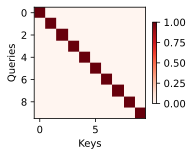

In [9]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

Nadaraya-Watson 核回归

 查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚， 注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。 在本节中，我们将介绍注意力汇聚的更多细节， 以便从宏观上了解注意力机制在实践中的运作方式。 具体来说，1964年提出的Nadaraya-Watson核回归模型 是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

##### 生成数据集  
由非线性函数生成一个人工数据集， 其中加入的噪声项s，其中s服从均值为和标准差为0.5的正态分布。 我们生成了个训练样本和个测试样本。 为了更好地可视化之后的注意力模式，我们将训练样本进行排序。

In [15]:
n_train=50
x_train, _=torch.sort(torch.rand(n_train)*5)

def f(x):
    return 2*torch.sin(x)+x**0.8

y_train=f(x_train)+torch.normal(0.0, 0.5, (n_train, ))
x_test=torch.arange(0, 5, 0.1)
y_truth=f(x_test)
n_test=len(x_test)
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数（标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）。

In [16]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

我们先使用最简单的估计器来解决回归问题： 基于平均汇聚来计算所有训练样本输出值的平均值：

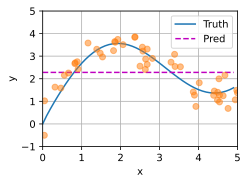

In [17]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

###### 非参数注意力汇聚
Nadaraya-Watson核回归是一个非参数模型。 因此， (10.2.6)是 非参数的注意力汇聚（nonparametric attention pooling）模型。 接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。 你会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

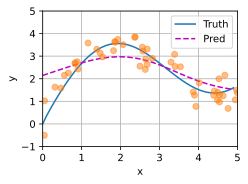

In [18]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

我们来观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

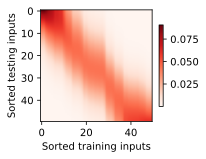

In [19]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

##### 带参数注意力汇聚
非参数的Nadaraya-Watson核回归具有一致性（consistency）的优点： 如果有足够的数据，此模型会收敛到最优结果。 尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

##### 批量矩阵乘法


In [20]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。

In [21]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

##### 定义模型

In [25]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.w=nn.Parameter(torch.rand(1,), requires_grad=True)

    def forward(self, quries, keys, values):
        quries=quries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights=nn.functional.softmax(-((quries-keys)*self.w)**2/2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

#### 训练
接下来，将训练数据集变换为键和值用于训练注意力模型。 在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [26]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意力汇聚模型时，使用平方损失函数和随机梯度下降。

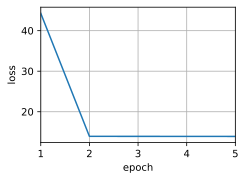

In [27]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所示，训练完带参数的注意力汇聚模型后，我们发现： 在尝试拟合带噪声的训练数据时， 预测结果绘制的线不如之前非参数模型的平滑。

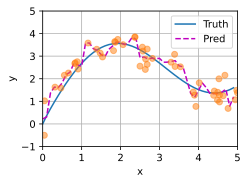

In [28]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

 我们看一下输出结果的绘制图： 与非参数的注意力汇聚模型相比， 带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑。

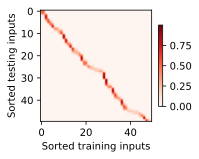

In [29]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')